# Identify hummingbirds

**Credit: [AITS cainvas](http://cainvas.ai-tech.systems/) authors**

![](https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/hummingbird.gif)


Differentiate between different species of birds is a task that requires experience and expertise. 

Here we will train neural networks to identify 3 species of hummingbirds, if they are in the image.

Deep learning models trained to identify birds and their species can be used to monitor wildlife over prolonged periods of time. Human intervention, support and input is necessary at times but this will drastically reduce the time and effort required for the task.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import layers, optimizers, models, preprocessing, losses, callbacks
import os
import random
from PIL import Image
import tensorflow as tf
import keras

# The dataset

The images in the datatset were all gathered from various hummingbird feeders in the towns of Morrison and Bailey, Colorado. [Kaggle](https://www.kaggle.com/akimball002/hummingbirds-at-my-feeders)

The dataset has 3 folders, train, test and valid, each with 100, 20 and 20 images of each class label.

The four labels in the dataset are - 
* No_bird
* Rufous_female
* Bradtailed_female
* Broadtailed_male


In [2]:
!wget -N "https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/hummingbirds.zip"
!unzip -qo hummingbirds.zip
!rm hummingbirds.zip

--2020-12-02 05:47:03--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/hummingbirds.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.62.72
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.62.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7363689 (7.0M) [application/zip]
Saving to: ‘hummingbirds.zip’

hummingbirds.zip    100%[===================>]   7.02M  --.-KB/s    in 0.04s   

2020-12-02 05:47:03 (190 MB/s) - ‘hummingbirds.zip’ saved [7363689/7363689]



In [3]:
# Loading the dataset

path = 'hummingbirds/'

batch = 32

# The train and test datasets
print("Train dataset")
train_ds = preprocessing.image_dataset_from_directory(path+'train', batch_size=batch)

print("Test dataset")
test_ds = preprocessing.image_dataset_from_directory(path+'test', batch_size=batch)

print("Validation dataset")
val_ds = preprocessing.image_dataset_from_directory(path+'valid', batch_size=batch)

Train dataset
Found 400 files belonging to 4 classes.
Test dataset
Found 80 files belonging to 4 classes.
Validation dataset
Found 80 files belonging to 4 classes.


In [4]:
# How many samples in each class

for t in ['train', 'test', 'valid']:
    print('\n', t.upper())
    for x in os.listdir(path + t):
        print(x, ' - ', len(os.listdir(path + t + '/' + x)))


 TRAIN
Broadtailed_female  -  100
No_bird  -  100
Broadtailed_male  -  100
Rufous_female  -  100

 TEST
Broadtailed_female  -  20
No_bird  -  20
Broadtailed_male  -  20
Rufous_female  -  20

 VALID
Broadtailed_female  -  20
No_bird  -  20
Broadtailed_male  -  20
Rufous_female  -  20


In [5]:
# Looking into the class labels

class_names = train_ds.class_names

print("Train class names: ", train_ds.class_names)
print("Test class names: ", test_ds.class_names)
print("Validation class names: ", val_ds.class_names)

Train class names:  ['Broadtailed_female', 'Broadtailed_male', 'No_bird', 'Rufous_female']
Test class names:  ['Broadtailed_female', 'Broadtailed_male', 'No_bird', 'Rufous_female']
Validation class names:  ['Broadtailed_female', 'Broadtailed_male', 'No_bird', 'Rufous_female']


In [6]:
# Looking into the shape of the batches and individual samples
# Set the input shape

print("Looking into the shape of images and labels in one batch\n")  

for image_batch, labels_batch in train_ds:
    input_shape = image_batch[0].shape
    print("Shape of images input for one batch: ", image_batch.shape)
    print("Shape of images labels for one batch: ", labels_batch.shape)
    break

Looking into the shape of images and labels in one batch

Shape of images input for one batch:  (32, 256, 256, 3)
Shape of images labels for one batch:  (32,)


# Visualization

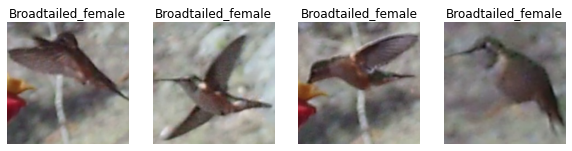

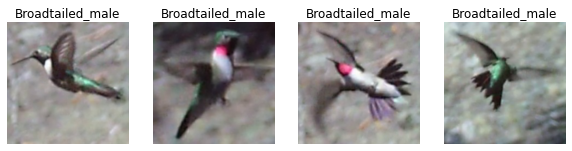

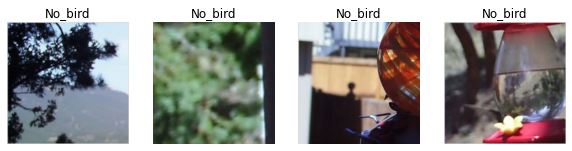

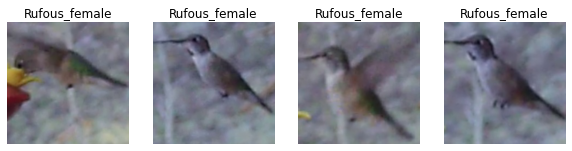

In [7]:
num_samples = 4    # the number of samples to be displayed in each class

for x in class_names:
    plt.figure(figsize=(10, 10))

    filenames = os.listdir(path + 'train/' + x)

    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        img = Image.open(path +'train/' + x + '/' + filenames[i])
        plt.imshow(img)
        plt.title(x)
        plt.axis("off")

# Preprocessing

## Normalization

In [8]:
# Normalizing the pixel values for faster convergence

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

## Augmentation

The training data has only 100 images. Image augmentation can aid in increasing the number of samples in the training dataset.

In [9]:
# Augmenting images in the train set to increase dataset size

data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),    # Flip using vertical axis
        layers.experimental.preprocessing.RandomZoom(0.1),    # Randomly zoom images in dataset
    ])


print("Train size (number of batches) before augmentation: ", len(train_ds))

# Apply only to train set    
aug_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

print("Size (number of batches) of augmented dataset: ", len(aug_ds))

#Adding to train_ds
train_ds = train_ds.concatenate(aug_ds)

print("Train size (number of batches) after augmentation: ", len(train_ds))

Train size (number of batches) before augmentation:  13
Size (number of batches) of augmented dataset:  13
Train size (number of batches) after augmentation:  26


# Model

Transfer learning gives a better result.

In [10]:
base_model = keras.applications.Xception(weights='imagenet', input_shape=input_shape, include_top=False)    # False, do not include the classification layer of the model

base_model.trainable = False

inputs = tf.keras.Input(shape=input_shape)

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(len(class_names), activation = 'softmax')(x)    # Add own classififcation layer

model = keras.Model(inputs, outputs)

cb = [callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)]

In [11]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(0.01), metrics=['accuracy'])

history = model.fit(train_ds, validation_data =  val_ds, epochs=32, callbacks = cb)

Epoch 1/32
26/26 [==============================] - 7s 276ms/step - loss: 0.5712 - accuracy: 0.7738 - val_loss: 0.3055 - val_accuracy: 0.8625
Epoch 2/32
26/26 [==============================] - 6s 236ms/step - loss: 0.1915 - accuracy: 0.9225 - val_loss: 0.2899 - val_accuracy: 0.8875
Epoch 3/32
26/26 [==============================] - 6s 232ms/step - loss: 0.1128 - accuracy: 0.9700 - val_loss: 0.3085 - val_accuracy: 0.8875
Epoch 4/32
26/26 [==============================] - 6s 233ms/step - loss: 0.0618 - accuracy: 0.9837 - val_loss: 0.3120 - val_accuracy: 0.8875
Epoch 5/32
26/26 [==============================] - 6s 237ms/step - loss: 0.0698 - accuracy: 0.9775 - val_loss: 0.3627 - val_accuracy: 0.8875
Epoch 6/32
26/26 [==============================] - 6s 237ms/step - loss: 0.1027 - accuracy: 0.9625 - val_loss: 0.2729 - val_accuracy: 0.9375
Epoch 7/32
26/26 [==============================] - 6s 239ms/step - loss: 0.0613 - accuracy: 0.9762 - val_loss: 0.2269 - val_accuracy: 0.9375
Epoch 

In [12]:
model.evaluate(test_ds)

3/3 [==============================] - 0s 83ms/step - loss: 0.3070 - accuracy: 0.9250


[0.30700889229774475, 0.925000011920929]

In [13]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(0.001), metrics=['accuracy'])

history1 = model.fit(train_ds, validation_data =  test_ds, epochs=32, callbacks = cb)

Epoch 1/32
26/26 [==============================] - 7s 270ms/step - loss: 0.0389 - accuracy: 0.9887 - val_loss: 0.2856 - val_accuracy: 0.9125
Epoch 2/32
26/26 [==============================] - 6s 247ms/step - loss: 0.0466 - accuracy: 0.9837 - val_loss: 0.2816 - val_accuracy: 0.9000
Epoch 3/32
26/26 [==============================] - 6s 243ms/step - loss: 0.0254 - accuracy: 0.9975 - val_loss: 0.2828 - val_accuracy: 0.9000
Epoch 4/32
26/26 [==============================] - 6s 243ms/step - loss: 0.0414 - accuracy: 0.9862 - val_loss: 0.3070 - val_accuracy: 0.8875
Epoch 5/32
26/26 [==============================] - 6s 245ms/step - loss: 0.0286 - accuracy: 0.9962 - val_loss: 0.3043 - val_accuracy: 0.9000
Epoch 6/32
26/26 [==============================] - 6s 248ms/step - loss: 0.0359 - accuracy: 0.9900 - val_loss: 0.2691 - val_accuracy: 0.9000
Epoch 7/32
26/26 [==============================] - 6s 244ms/step - loss: 0.0296 - accuracy: 0.9937 - val_loss: 0.2899 - val_accuracy: 0.9125
Epoch 

In [14]:
model.evaluate(test_ds)

3/3 [==============================] - 0s 95ms/step - loss: 0.2490 - accuracy: 0.9250


[0.24899382889270782, 0.925000011920929]

# Plotting the metrics

In [15]:
def plot(history1, history2, variable1, variable2):
    # combining metrics from both trainings    
    var1_history = history1[variable1]
    var1_history.extend(history2[variable1])
    
    var2_history = history1[variable2]
    var2_history.extend(history2[variable2])
    
    # plotting them
    plt.plot(range(len(var1_history)), var1_history)
    plt.plot(range(len(var2_history)), var2_history)
    plt.legend([variable1, variable2])
    plt.title(variable1)

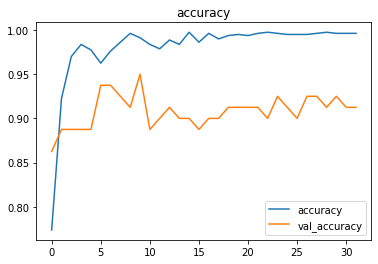

In [16]:
plot(history.history, history1.history, "accuracy", 'val_accuracy')

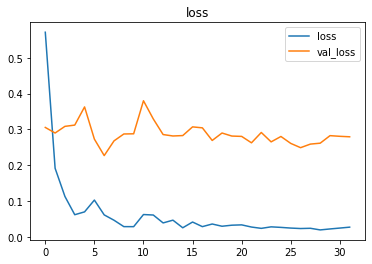

In [17]:
plot(history.history, history1.history, "loss", 'val_loss')

# Prediction

Prdicted:  No_bird
True:  No_bird
Probability:  0.9978399


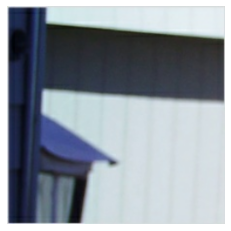

In [18]:
# pick random test data sample from one batch
x = random.randint(0, batch - 1)

for i in test_ds.as_numpy_iterator():
    img, label = i    
    plt.axis('off')   # remove axes
    plt.imshow(img[x])    # shape from (32, 256, 256, 3) --> (256, 256, 3)
    output = model.predict(np.expand_dims(img[x],0))    # getting output; input shape (256, 256, 3) --> (1, 256, 256, 3)
    pred = np.argmax(output[0])    # finding max
    print("Prdicted: ", class_names[pred])    # Picking the label from class_names base don the model output
    print("True: ", class_names[label[x]])
    print("Probability: ", output[0][pred])
    break

# deepC

In [19]:
model.save('hummingbird.h5')

!deepCC hummingbird.h5

reading [keras model] from 'hummingbird.h5'
Saved 'hummingbird.onnx'
reading onnx model from file  hummingbird.onnx
Model info:
  ir_vesion :  5 
  doc       : 
WARN (ONNX): graph-node conv2d's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block2_sepconv10's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block2_sepconv11's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block2_sepconv20's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block2_sepconv21's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node conv2d_1's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block3_sepconv10's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block3_sepconv11's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block3_sepconv20's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block3_sepconv21's attribute auto_pad has no meaningful dat